In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [2]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon) 
        f = f1_score(gt, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

Number of datapoints in training set: 307
Number of dimensions/features: 2
[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


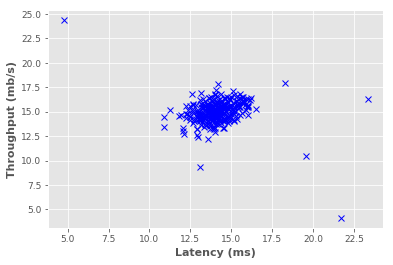

In [3]:
tr_data = read_dataset('tr_server_data.csv') 
cv_data = read_dataset('cv_server_data.csv') 
gt_data = read_dataset('gt_server_data.csv')

n_training_samples = tr_data.shape[0]
n_dim = tr_data.shape[1]

print('Number of datapoints in training set: %d' % n_training_samples)
print('Number of dimensions/features: %d' % n_dim)


print(tr_data[1:5,:])

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.show()

In [4]:
mu, sigma = estimateGaussian(tr_data)
p = multivariateGaussian(tr_data,mu,sigma)

In [5]:
#selecting optimal value of epsilon using cross validation
p_cv = multivariateGaussian(cv_data,mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,gt_data)
print(fscore, ep)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8750000000000001 9.036201327981216e-05


In [6]:
#selecting outlier datapoints 
outliers = np.asarray(np.where(p < ep))

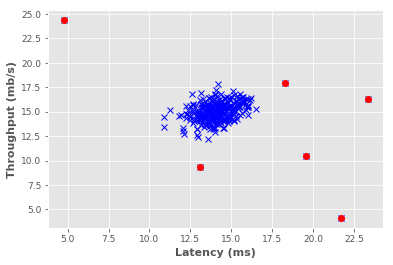

In [7]:
plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.plot(tr_data[outliers,0],tr_data[outliers,1],'ro')
plt.show()

## Anomaly Detection Using One-Class SVM

In [8]:
from sklearn import svm

In [9]:
# use the same dataset
tr_data = read_dataset('tr_server_data.csv')

In [10]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(tr_data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [11]:
pred = clf.predict(tr_data)

# inliers are labeled 1, outliers are labeled -1
normal = tr_data[pred == 1]
abnormal = tr_data[pred == -1]

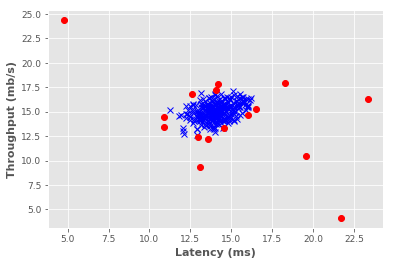

In [12]:
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()